# **Import needed libraries**

In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the dataset**

> Read the training dataset into the dataframe

In [2]:
# Generate data paths with labels
train_data_dir = "Data/Brain Tumor/Training"
filepaths = []
labels = []

# Get folders names
folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
train_df

,filepaths,labels
0,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
1,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
2,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
3,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
4,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
...,...,...
5707,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary
5708,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary
5709,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary
5710,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary


> read the testing dataset into the dataframe

In [4]:
# Generate data paths with labels
test_data_dir = 'Data/Brain Tumor/Testing'
filepaths = []
labels = []

# Get folders names
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [5]:
ts_df

,filepaths,labels
0,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
1,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
2,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
3,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
4,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,glioma
...,...,...
1306,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary
1307,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary
1308,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary
1309,C:\Users\Chimni\Desktop\Dr-DiagnoSense\Data\Br...,pituitary


# **Data preprocessing**

first we will check if the training data is balanced or not

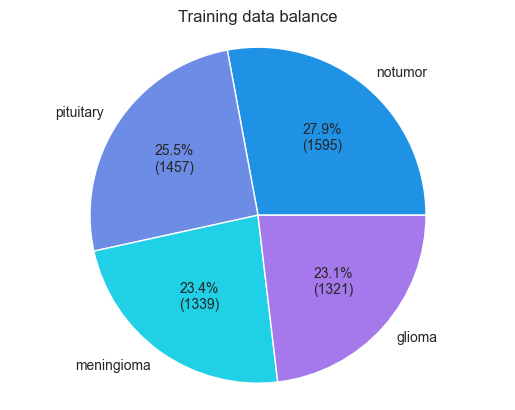

In [6]:
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

**data is balanced.**

**now we will split the testing data to test and validation data**

In [7]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

**Create image data generator**

this step to convert these dataframes to numpy array

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


**Display sample from train data**

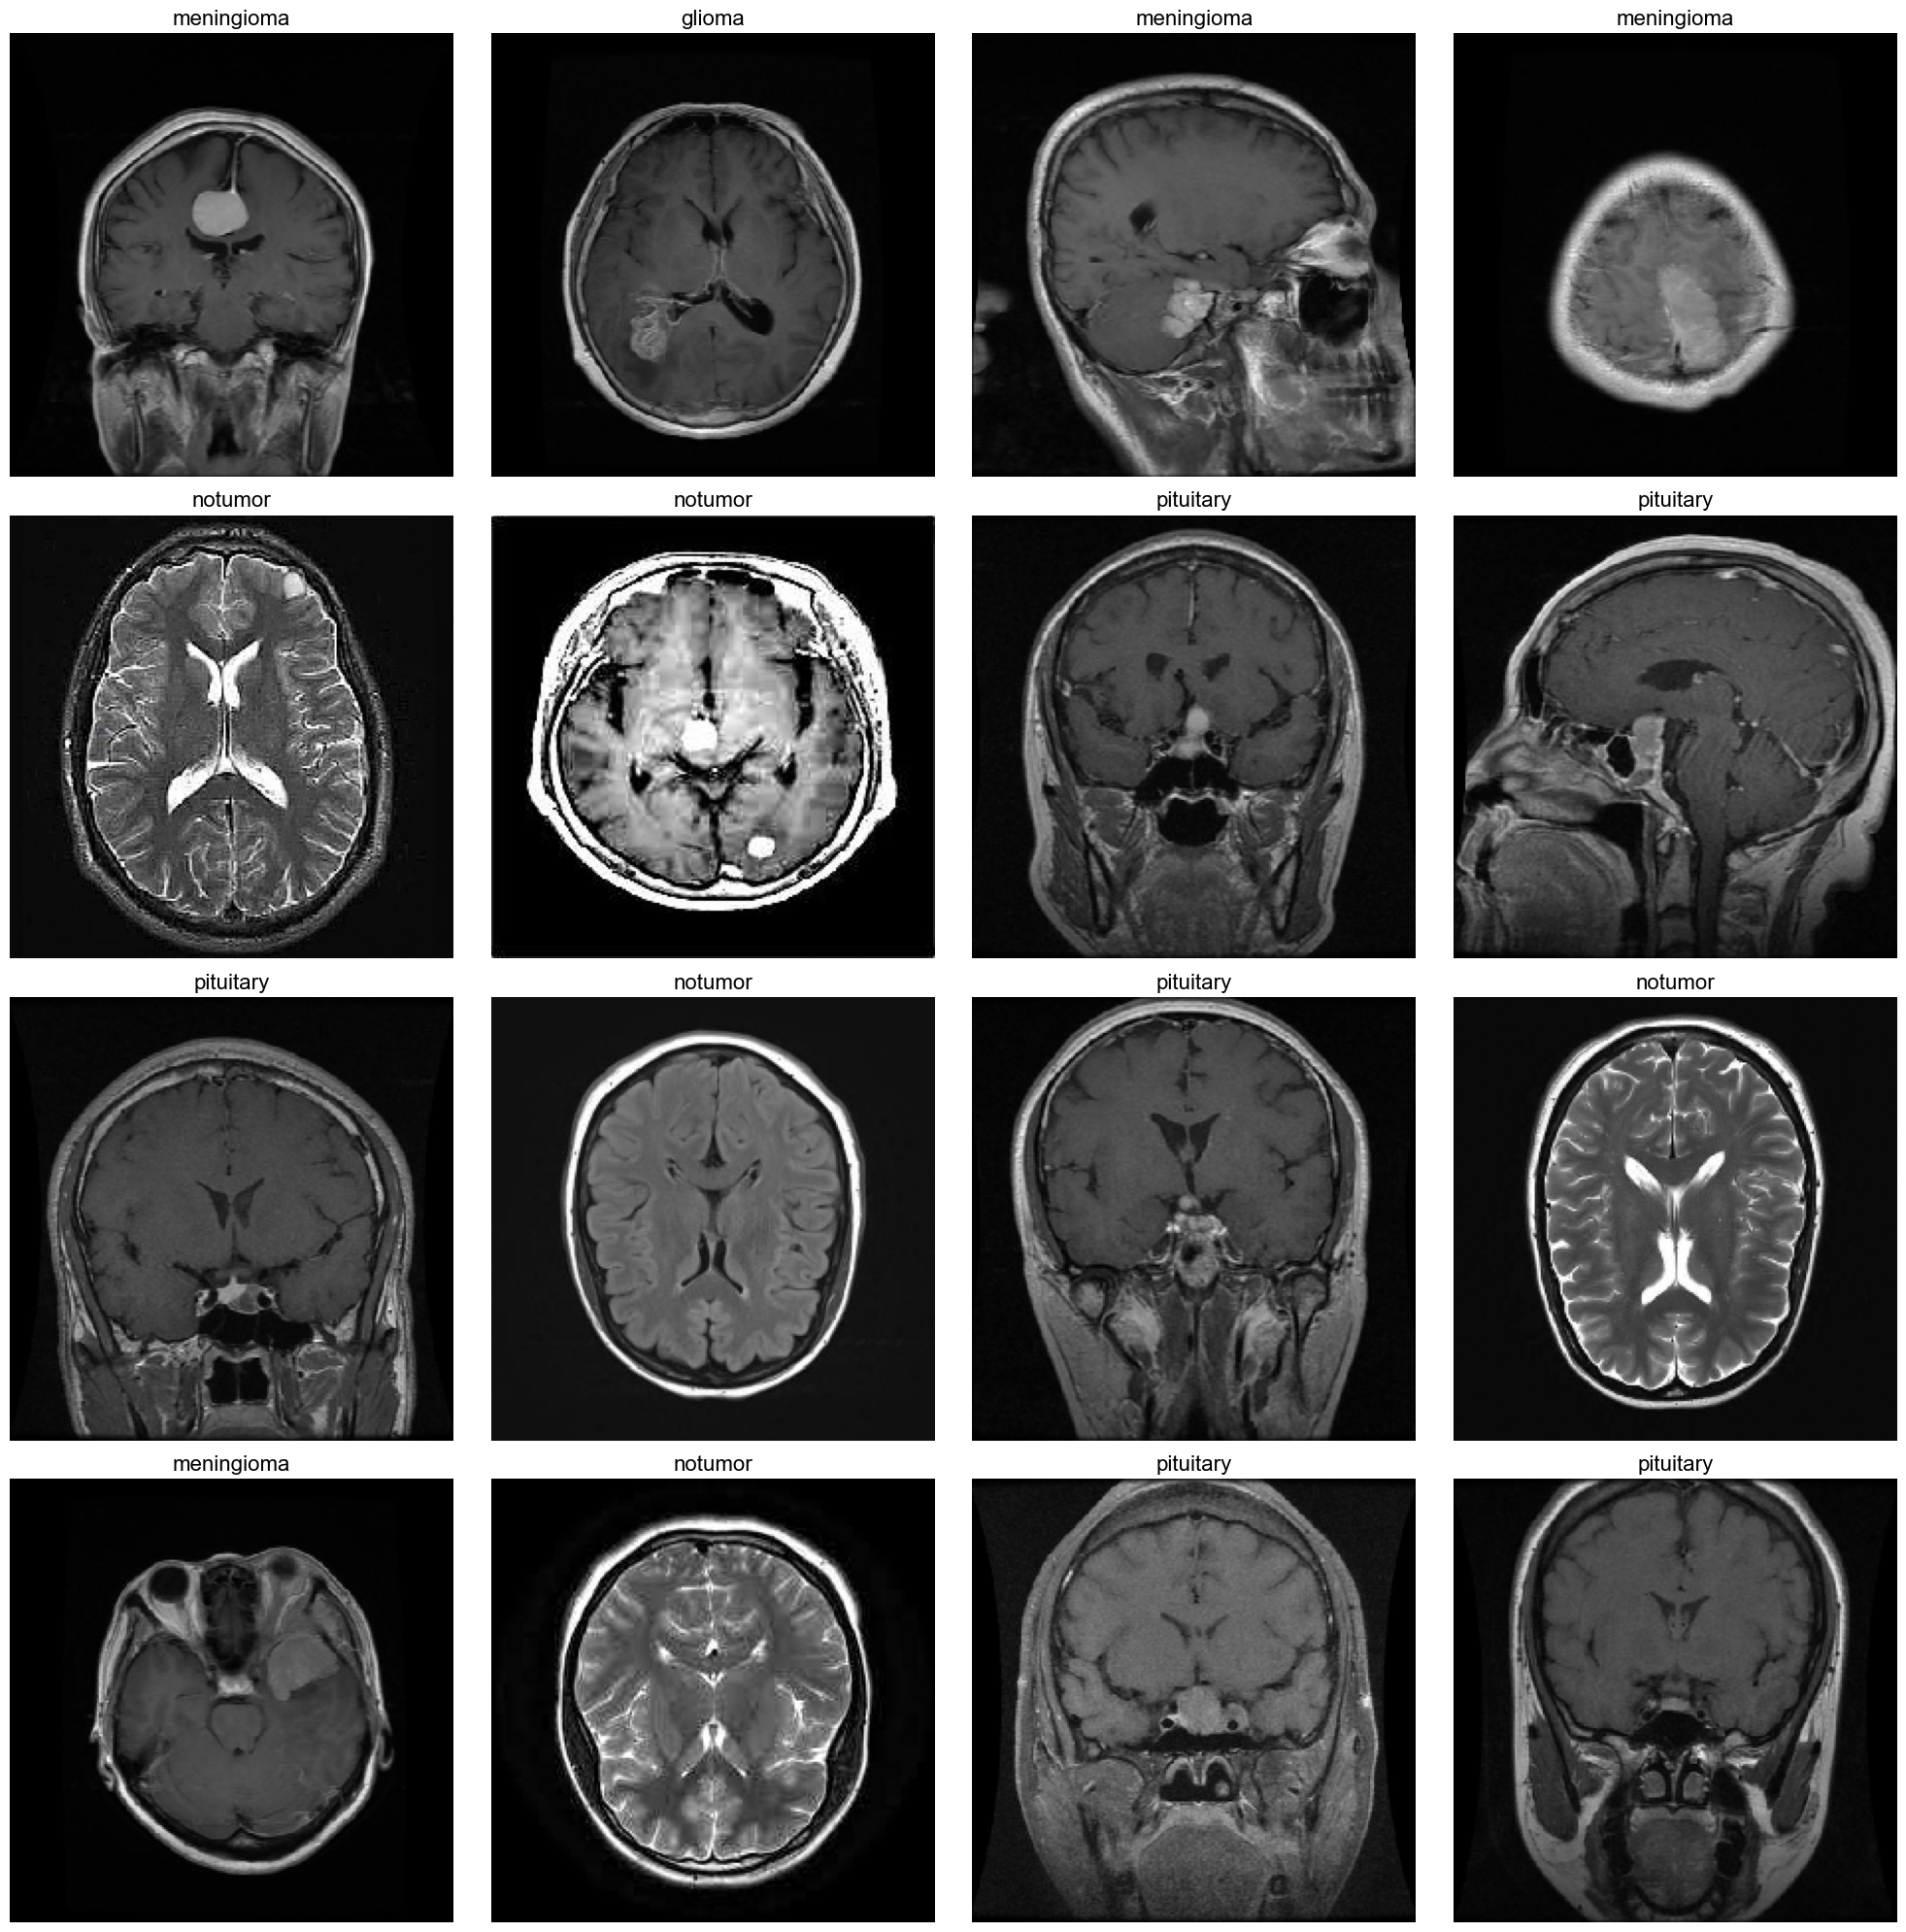

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Model Structure**

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())
    
model.add(Flatten())
    
model.add(Dense(64,activation = "relu"))
model.add(Dense(32,activation = "relu"))
model.add(Dense(class_count, activation = "softmax"))


In [11]:
# Compile model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 66s 182ms/step - accuracy: 0.6223 - loss: 64.9773 - val_accuracy: 0.8641 - val_loss: 0.4628
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 61s 170ms/step - accuracy: 0.9183 - loss: 0.2773 - val_accuracy: 0.9298 - val_loss: 0.2324
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 61s 171ms/step - accuracy: 0.9700 - loss: 0.1194 - val_accuracy: 0.9359 - val_loss: 0.2442
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 65s 182ms/step - accuracy: 0.9852 - loss: 0.0668 - val_accuracy: 0.9420 - val_loss: 0.2110
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 61s 171ms/step - accuracy: 0.9950 - loss: 0.0281 - val_accuracy: 0.9496 - val_loss: 0.2022
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 254s 714ms/step - accuracy: 0.9968 - loss: 0.0173 - val_accuracy: 0.9511 - val_loss: 0.1694
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 63s 175ms/step - accuracy: 0.9962 - loss: 0.0284 - val_accuracy: 0.9527 - val_loss: 0.1804
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 63s 175ms/step - accuracy: 0.9973 - loss:

In [13]:
# Create a new MLP model
model2 = Sequential([
    Flatten(input_shape=img_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(class_count, activation='softmax')
])

model2.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.5497 - loss: 602.5715 - val_accuracy: 0.6885 - val_loss: 186.7900
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - accuracy: 0.6988 - loss: 189.0492 - val_accuracy: 0.7221 - val_loss: 298.3336
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.7379 - loss: 149.0985 - val_accuracy: 0.7328 - val_loss: 153.7339
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.7742 - loss: 110.8440 - val_accuracy: 0.7282 - val_loss: 130.3062
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.7917 - loss: 82.3030 - val_accuracy: 0.8076 - val_loss: 71.2595
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.8060 - loss: 68.1178 - val_accuracy: 0.7145 - val_loss: 78.6429
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.7914 - loss: 58.8697 - val_accuracy: 0.7221 - val_loss: 97.9107
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.

In [14]:
# Print model summary
model2.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,276,228 (73.53 MB)

 Trainable params: 19,276,228 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Load the VGG16 model without the top (fully connected) layers
vgg_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the VGG16 base model
vgg_base.trainable = False

# Create a new model on top of the VGG16 base
model3 = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

model3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)



Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.7789 - loss: 7.1115 - val_accuracy: 0.9344 - val_loss: 0.2593
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.9609 - loss: 0.1486 - val_accuracy: 0.9542 - val_loss: 0.1723
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.9799 - loss: 0.0640 - val_accuracy: 0.9542 - val_loss: 0.1485
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 386s 1s/step - accuracy: 0.9900 - loss: 0.0377 - val_accuracy: 0.9756 - val_loss: 0.0801
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.9901 - loss: 0.0309 - val_accuracy: 0.9740 - val_loss: 0.1281
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.9902 - loss: 0.0262 - val_accuracy: 0.9588 - val_loss: 0.2240
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9930 - loss: 0.0194 - val_accuracy: 0.9176 - val_loss: 0.3746
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.9937 - loss: 0.0341 - val_accu

In [16]:
# Print model summary
model3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Display Model Performance

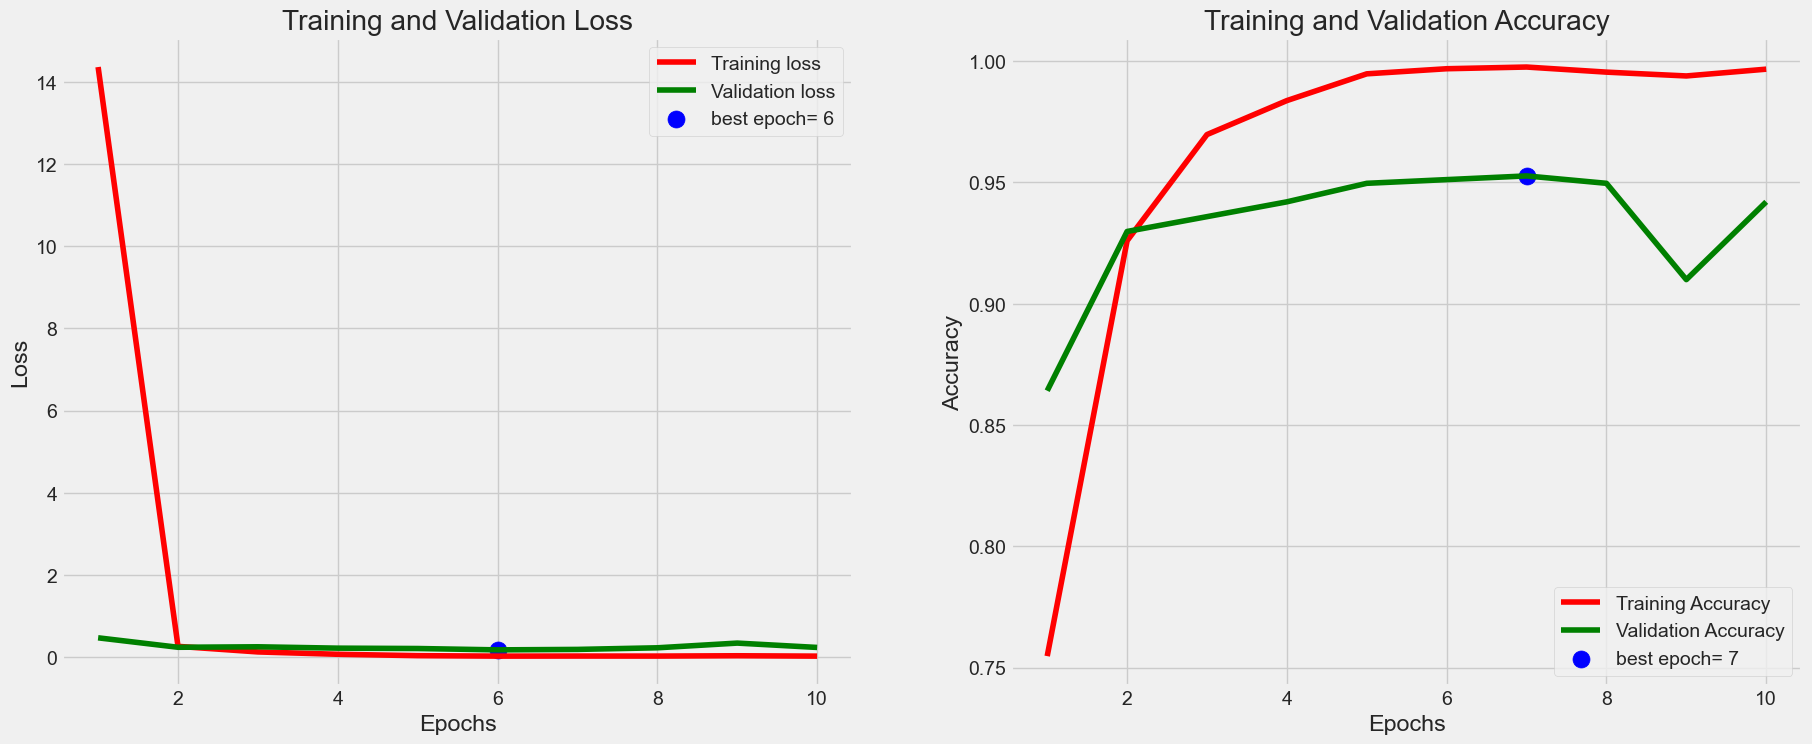

In [22]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

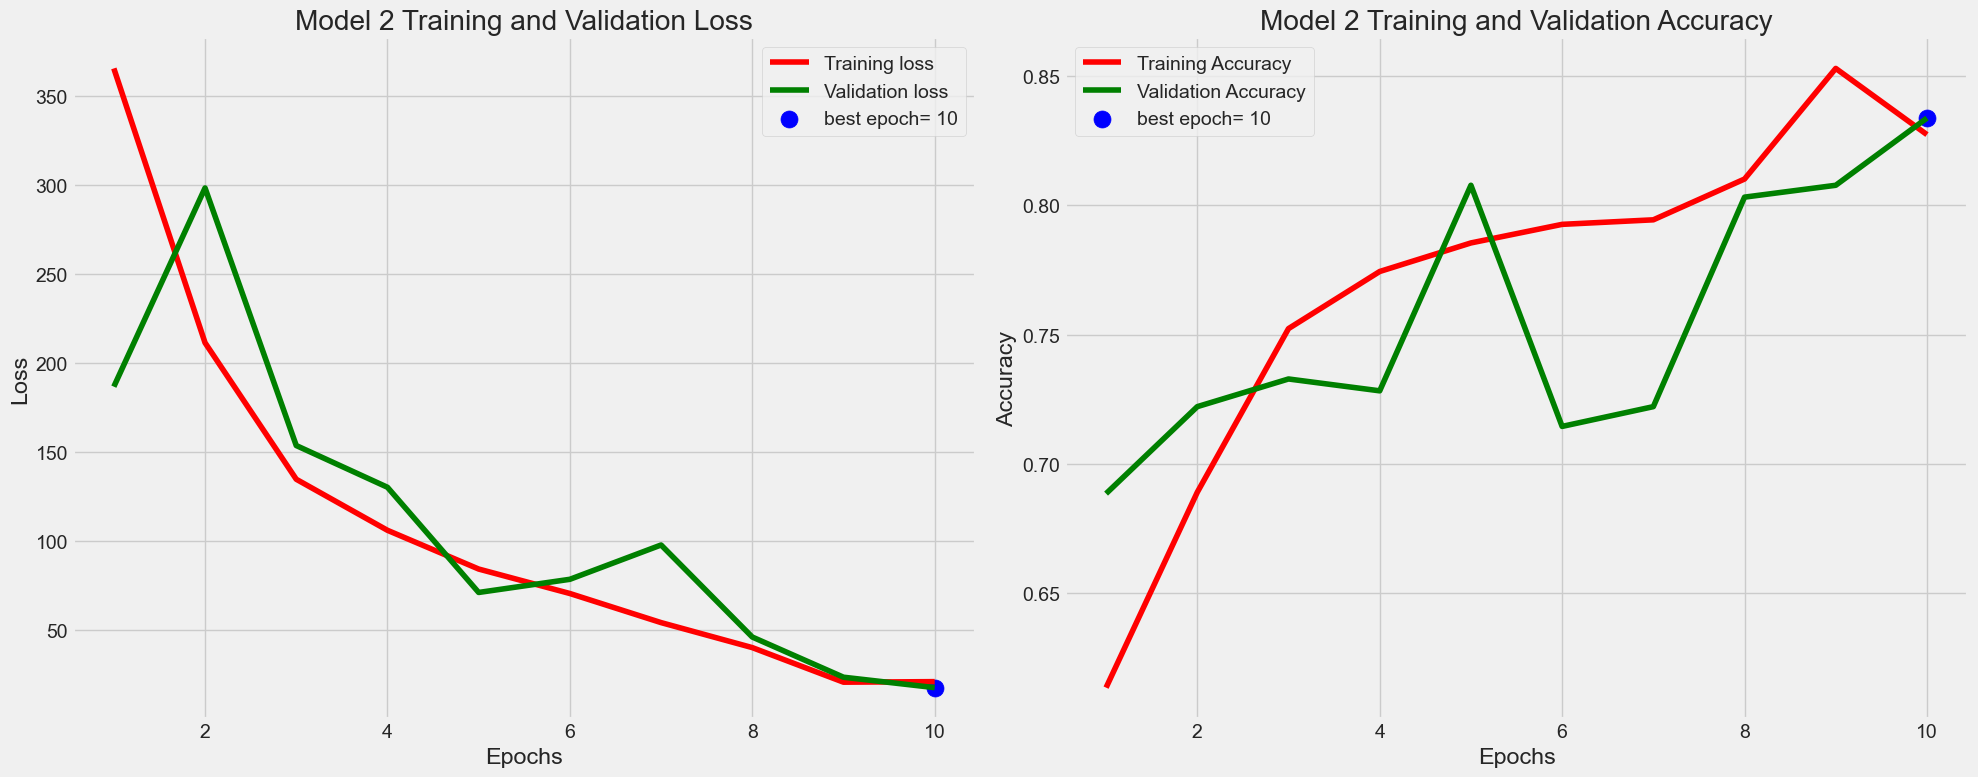

In [23]:
# Define needed variables for model2
tr_acc_model2 = history2.history['accuracy']
tr_loss_model2 = history2.history['loss']
val_acc_model2 = history2.history['val_accuracy']
val_loss_model2 = history2.history['val_loss']
index_loss_model2 = np.argmin(val_loss_model2)
val_lowest_model2 = val_loss_model2[index_loss_model2]
index_acc_model2 = np.argmax(val_acc_model2)
acc_highest_model2 = val_acc_model2[index_acc_model2]

Epochs_model2 = [i+1 for i in range(len(tr_acc_model2))]
loss_label_model2 = f'best epoch= {str(index_loss_model2 + 1)}'
acc_label_model2 = f'best epoch= {str(index_acc_model2 + 1)}'

# Plot training history for model2
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model2, tr_loss_model2, 'r', label='Training loss')
plt.plot(Epochs_model2, val_loss_model2, 'g', label='Validation loss')
plt.scatter(index_loss_model2 + 1, val_lowest_model2, s=150, c='blue', label=loss_label_model2)
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model2, tr_acc_model2, 'r', label='Training Accuracy')
plt.plot(Epochs_model2, val_acc_model2, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model2 + 1, acc_highest_model2, s=150, c='blue', label=acc_label_model2)
plt.title('Model 2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


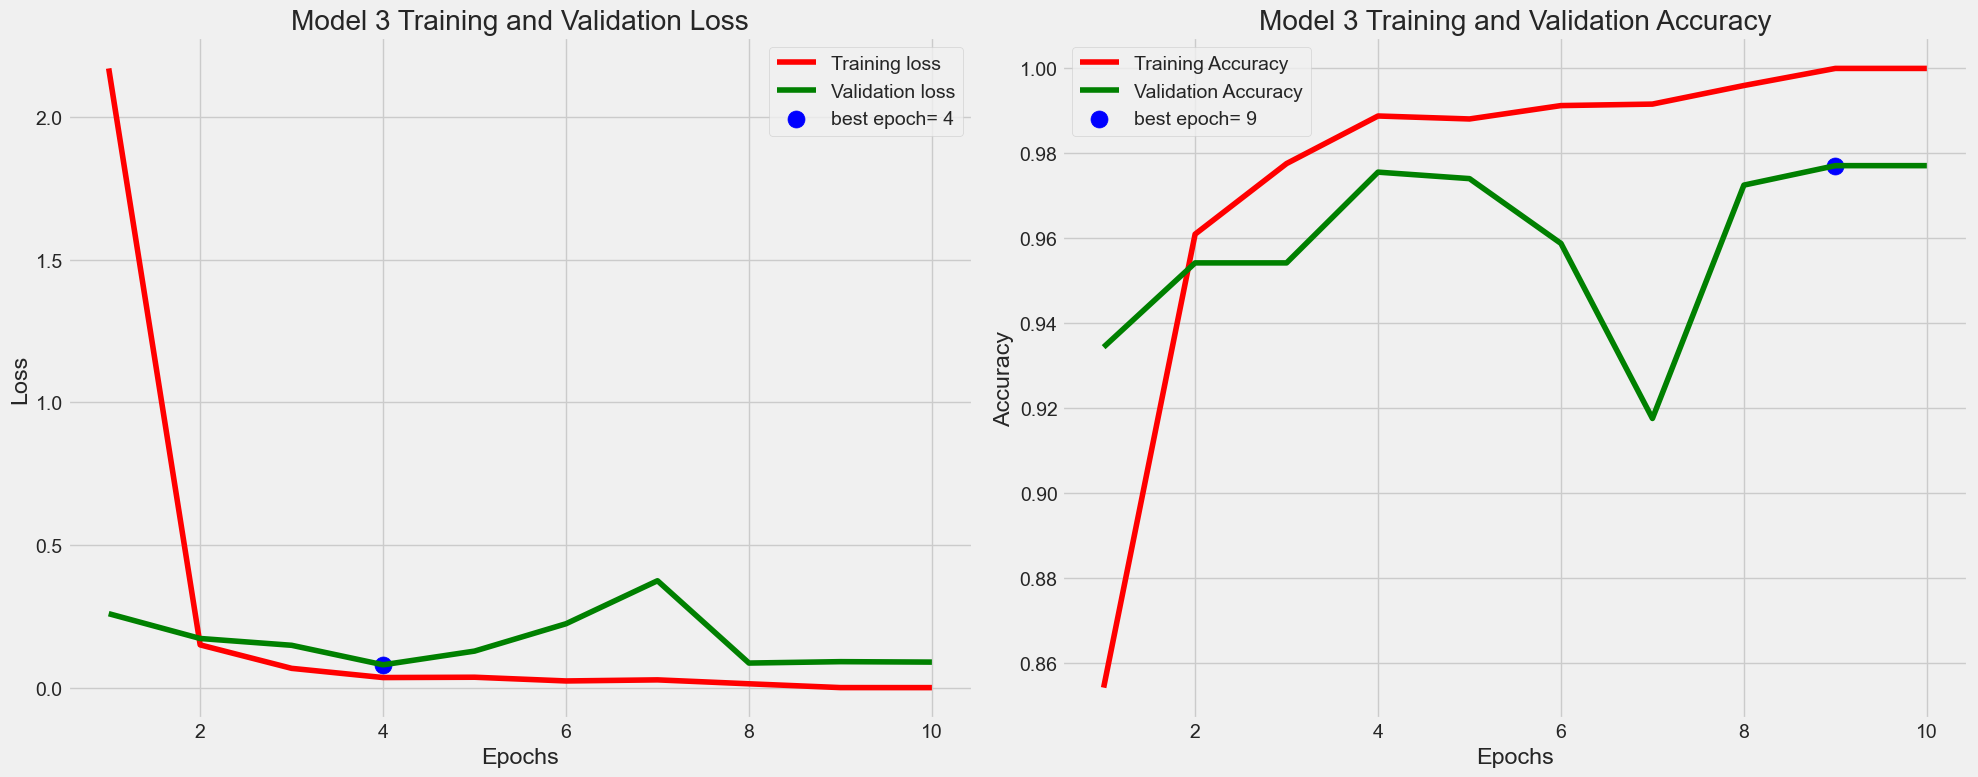

In [24]:
# Define needed variables for model3
tr_acc_model3 = history3.history['accuracy']
tr_loss_model3 = history3.history['loss']
val_acc_model3 = history3.history['val_accuracy']
val_loss_model3 = history3.history['val_loss']
index_loss_model3 = np.argmin(val_loss_model3)
val_lowest_model3 = val_loss_model3[index_loss_model3]
index_acc_model3 = np.argmax(val_acc_model3)
acc_highest_model3 = val_acc_model3[index_acc_model3]

Epochs_model3 = [i+1 for i in range(len(tr_acc_model3))]
loss_label_model3 = f'best epoch= {str(index_loss_model3 + 1)}'
acc_label_model3 = f'best epoch= {str(index_acc_model3 + 1)}'

# Plot training history for model3
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model3, tr_loss_model3, 'r', label='Training loss')
plt.plot(Epochs_model3, val_loss_model3, 'g', label='Validation loss')
plt.scatter(index_loss_model3 + 1, val_lowest_model3, s=150, c='blue', label=loss_label_model3)
plt.title('Model 3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model3, tr_acc_model3, 'r', label='Training Accuracy')
plt.plot(Epochs_model3, val_acc_model3, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model3 + 1, acc_highest_model3, s=150, c='blue', label=acc_label_model3)
plt.title('Model 3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate Model

In [25]:
##CNN
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9917 - loss: 0.0292
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9549 - loss: 0.1601
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9095 - loss: 0.4499
Train Loss:  0.027460208162665367
Train Accuracy:  0.9917716979980469
--------------------
Validation Loss:  0.22841471433639526
Validation Accuracy:  0.9419847130775452
--------------------
Test Loss:  0.5054648518562317
Test Accuracy:  0.9131097793579102


In [26]:
#MLP Tensorflow
train_score_model2 = model2.evaluate(train_gen, verbose=1)
valid_score_model2 = model2.evaluate(valid_gen, verbose=1)
test_score_model2 = model2.evaluate(test_gen, verbose=1)

print("Model 2 Train Loss: ", train_score_model2[0])
print("Model 2 Train Accuracy: ", train_score_model2[1])
print('-' * 20)
print("Model 2 Validation Loss: ", valid_score_model2[0])
print("Model 2 Validation Accuracy: ", valid_score_model2[1])
print('-' * 20)
print("Model 2 Test Loss: ", test_score_model2[0])
print("Model 2 Test Accuracy: ", test_score_model2[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9055 - loss: 6.2409
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8495 - loss: 16.4643
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8265 - loss: 21.5222
Model 2 Train Loss:  6.637612342834473
Model 2 Train Accuracy:  0.9058123230934143
--------------------
Model 2 Validation Loss:  17.838306427001953
Model 2 Validation Accuracy:  0.8335877656936646
--------------------
Model 2 Test Loss:  27.872400283813477
Model 2 Test Accuracy:  0.8094512224197388


In [27]:
#VGG16
train_score_model3 = model3.evaluate(train_gen, verbose=1)
valid_score_model3 = model3.evaluate(valid_gen, verbose=1)
test_score_model3 = model3.evaluate(test_gen, verbose=1)

print("Model 3 Train Loss: ", train_score_model3[0])
print("Model 3 Train Accuracy: ", train_score_model3[1])
print('-' * 20)
print("Model 3 Validation Loss: ", valid_score_model3[0])
print("Model 3 Validation Accuracy: ", valid_score_model3[1])
print('-' * 20)
print("Model 3 Test Loss: ", test_score_model3[0])
print("Model 3 Test Accuracy: ", test_score_model3[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 1.0000 - loss: 9.8067e-05
41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9711 - loss: 0.1388
41/41 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9775 - loss: 0.0775
Model 3 Train Loss:  9.80880213319324e-05
Model 3 Train Accuracy:  1.0
--------------------
Model 3 Validation Loss:  0.08956138789653778
Model 3 Validation Accuracy:  0.9770992398262024
--------------------
Model 3 Test Loss:  0.1545071303844452
Model 3 Test Accuracy:  0.9725610017776489


## Get Predictions

In [28]:
#CNN
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


In [29]:
#MLP
preds_model2 = model2.predict(test_gen)  
y_pred_model2 = np.argmax(preds_model2, axis=1) 


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [30]:
#VGG16
preds_model3 = model3.predict(test_gen)  
y_pred_model3 = np.argmax(preds_model3, axis=1) 


41/41 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step


## Confusion Matrices and Classification report

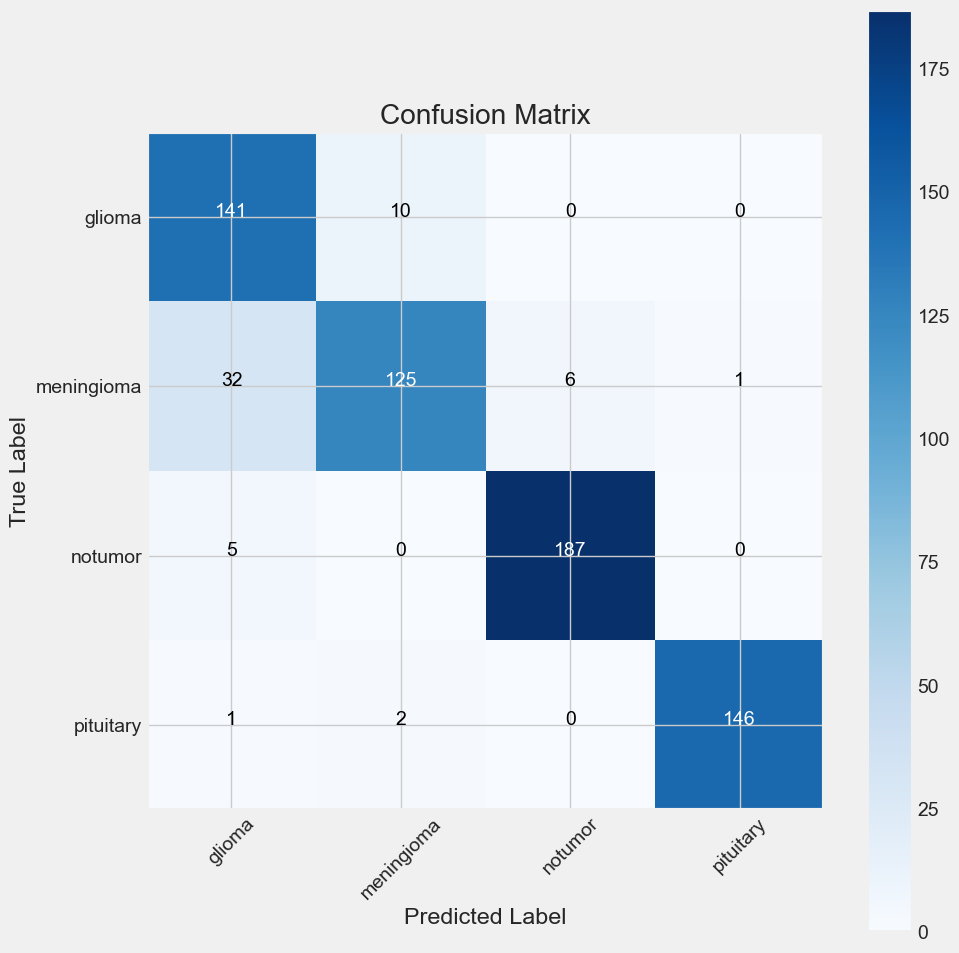

In [31]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

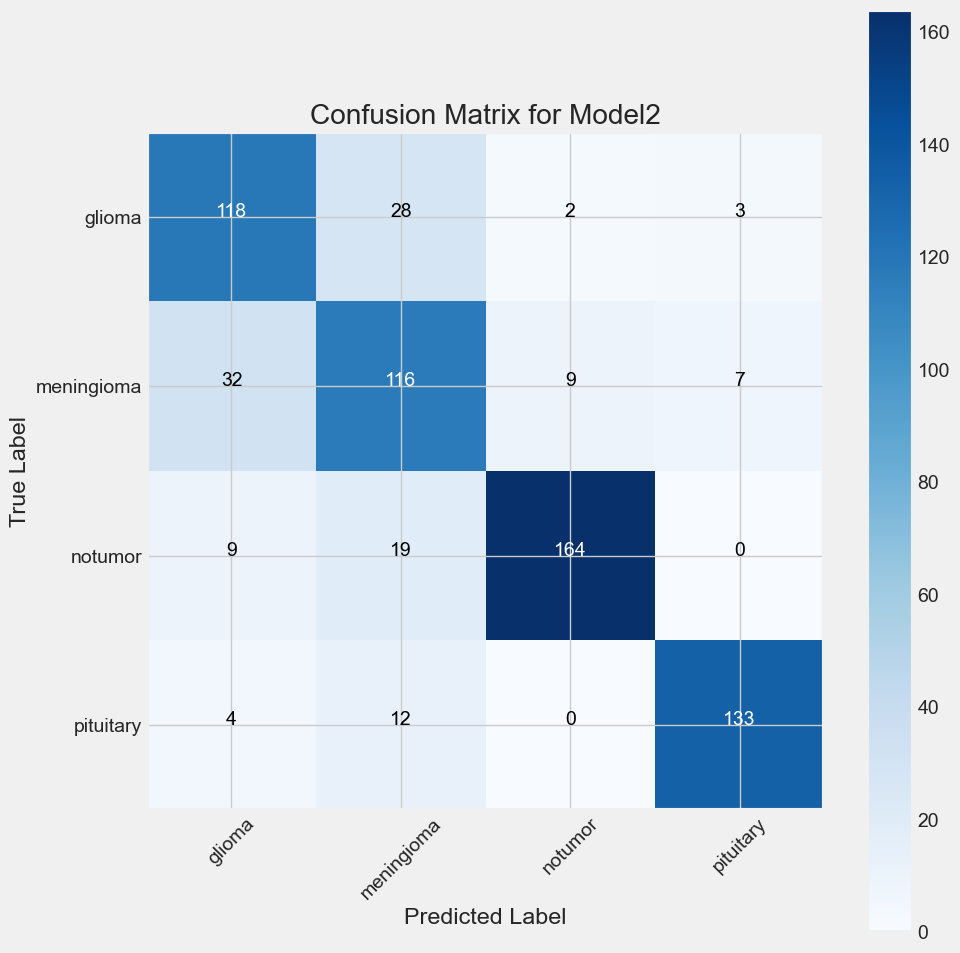

In [32]:
g_dict_model2 = test_gen.class_indices
classes_model2 = list(g_dict_model2.keys())

# Confusion matrix for model2
cm_model2 = confusion_matrix(test_gen.classes, y_pred_model2)
cm_model2

plt.figure(figsize= (10, 10))
plt.imshow(cm_model2, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model2')
plt.colorbar()

tick_marks_model2 = np.arange(len(classes_model2))
plt.xticks(tick_marks_model2, classes_model2, rotation= 45)
plt.yticks(tick_marks_model2, classes_model2)

thresh_model2 = cm_model2.max() / 2.
for i, j in itertools.product(range(cm_model2.shape[0]), range(cm_model2.shape[1])):
    plt.text(j, i, cm_model2[i, j], horizontalalignment= 'center', color= 'white' if cm_model2[i, j] > thresh_model2 else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


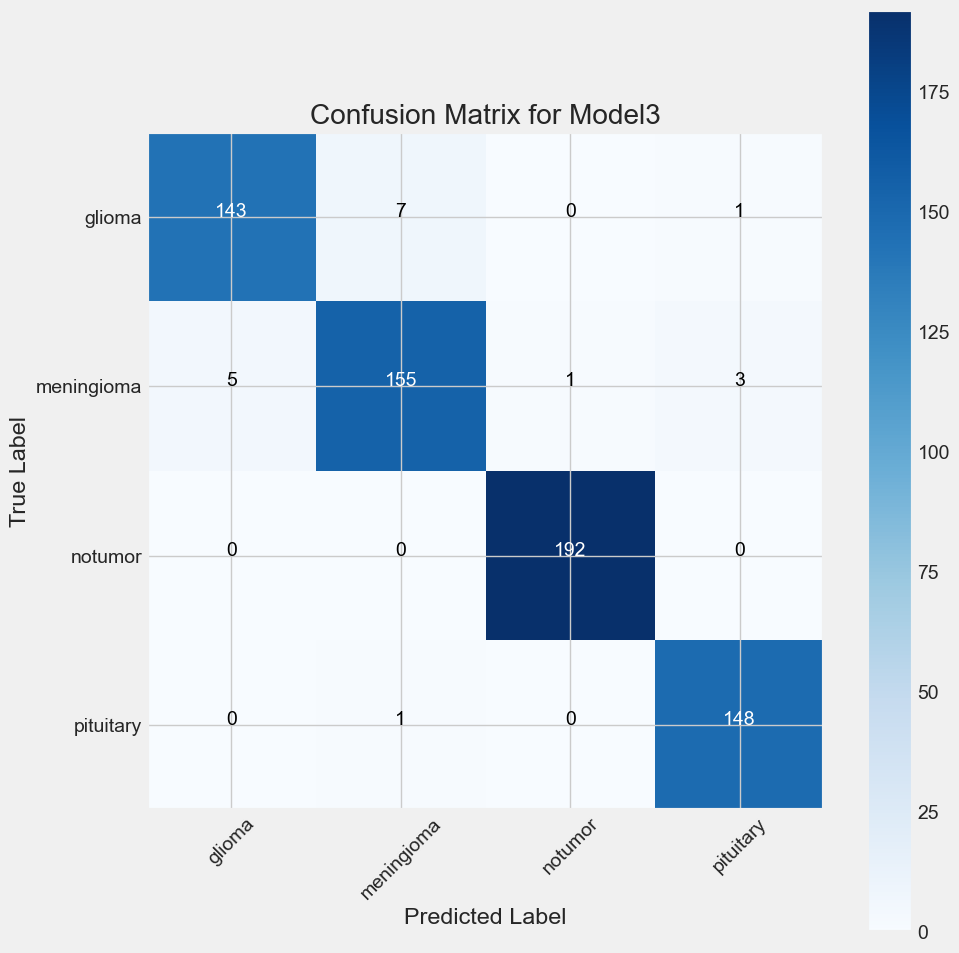

In [33]:
g_dict_model3 = test_gen.class_indices
classes_model3 = list(g_dict_model3.keys())

# Confusion matrix for model3
cm_model3 = confusion_matrix(test_gen.classes, y_pred_model3)
cm_model3

plt.figure(figsize= (10, 10))
plt.imshow(cm_model3, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix for Model3')
plt.colorbar()

tick_marks_model3 = np.arange(len(classes_model3))
plt.xticks(tick_marks_model3, classes_model3, rotation= 45)
plt.yticks(tick_marks_model3, classes_model3)

thresh_model3 = cm_model3.max() / 2.
for i, j in itertools.product(range(cm_model3.shape[0]), range(cm_model3.shape[1])):
    plt.text(j, i, cm_model3[i, j], horizontalalignment= 'center', color= 'white' if cm_model3[i, j] > thresh_model3 else 'black')
    
    
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [34]:
#CNN Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.79      0.93      0.85       151
  meningioma       0.91      0.76      0.83       164
     notumor       0.97      0.97      0.97       192
   pituitary       0.99      0.98      0.99       149

    accuracy                           0.91       656
   macro avg       0.92      0.91      0.91       656
weighted avg       0.92      0.91      0.91       656



In [35]:
#MLP Classificatoin Report
print(classification_report(test_gen.classes, y_pred_model2, target_names= classes_model2))


              precision    recall  f1-score   support

      glioma       0.72      0.78      0.75       151
  meningioma       0.66      0.71      0.68       164
     notumor       0.94      0.85      0.89       192
   pituitary       0.93      0.89      0.91       149

    accuracy                           0.81       656
   macro avg       0.81      0.81      0.81       656
weighted avg       0.82      0.81      0.81       656



In [36]:
#VGG16 Classification Report
print(classification_report(test_gen.classes, y_pred_model3, target_names= classes_model3))


              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       151
  meningioma       0.95      0.95      0.95       164
     notumor       0.99      1.00      1.00       192
   pituitary       0.97      0.99      0.98       149

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



## Saving the best model as h5

In [ ]:
import os

# Define the directory path for the "Web App" folder
dir_path = os.path.abspath("Web App")

# Define a ModelCheckpoint callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(os.path.join(dir_path, 'best_model.keras'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model with the ModelCheckpoint callback
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False, callbacks=[checkpoint])

# Evaluate the best model on the test set
best_model = keras.models.load_model(os.path.join(dir_path, 'best_model.keras'))
test_score = best_model.evaluate(test_gen, verbose=1)

print("Best Model Test Loss: ", test_score[0])
print("Best Model Test Accuracy: ", test_score[1])
